In [1]:
import matplotlib.pyplot as plt
import os 
import random
from tqdm.notebook import trange, tqdm
import sys 

import mitsuba as mi 
print(mi.variants())
mi.set_variant('cuda_ad_rgb')

import torch
from torch import nn
from torch.nn import functional as F
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    raise Exception('No GPU available, please use a GPU to train your neural network.')
print(device)

['scalar_rgb', 'scalar_spectral', 'cuda_ad_rgb', 'llvm_ad_rgb']
cuda


In [2]:
objects = os.listdir('data/03001627')
objects = ['data/03001627/' + o + "/models/model_normalized.obj" for o in objects]
print("objects: ", len(objects))

objects:  6778


In [3]:
SCALE = 0.8
SIZE = 128
NVIEW = 8
# N = 1000
N = 2000

def load_sensor_random():
    look_at = mi.ScalarTransform4f.look_at(
        origin=[2, 1, 0],
        target=[0, 0, 0],
        up=[0, 1, 0]
    )
    scale = mi.ScalarTransform4f.scale([SCALE, SCALE, SCALE])
    rotation = mi.ScalarTransform4f.rotate([0, 1, 0], 360 * random.random())
    trans = scale @ rotation @ look_at

    return mi.load_dict({
        'type' : 'orthographic',
        'film' : {
            'type' : 'hdrfilm',
            'width' : SIZE,
            'height' : SIZE,
            'banner' : False
        },
        'sampler' : {
            'type' : 'multijitter'
        },
        'to_world' : trans
    })

def load_sensor_fixed(id):
    look_at = mi.ScalarTransform4f.look_at(
        origin=[2, 1, 0],
        target=[0, 0, 0],
        up=[0, 1, 0]
    )
    scale = mi.ScalarTransform4f.scale([SCALE, SCALE, SCALE])
    rotation = mi.ScalarTransform4f.rotate([0, 1, 0], 360 * id / NVIEW )
    trans = scale @ rotation @ look_at

    return mi.load_dict({
        'type' : 'orthographic',
        'film' : {
            'type' : 'hdrfilm',
            'width' : SIZE,
            'height' : SIZE,
            'banner' : False
        },
        'sampler' : {
            'type' : 'multijitter'
        },
        'to_world' : trans
    })

In [4]:
SEED = 0
random.seed(SEED)
images = []
pbar = tqdm(total=N, file=sys.stdout)
for i in range(N):
    path = objects[i]
    scene = {
        'type' : 'scene',
        'integrator' : {
            'type' : 'path'
        },
        'emitter' : {
            'type': 'envmap',
            'filename': 'data/envmap/lonely_road_afternoon_puresky_1k.exr',
        },
        'shape' : {
            'type' : 'obj',
            'filename' : path,
            'bsdf' : {
                'type': 'twosided',
                'material' : {
                'type' : 'diffuse',
                    'reflectance' : {
                        'type' : 'rgb',
                        'value' : [0.8, 0.8, 0.8]
                    }
                }
            }
        }
    }
    try: 
        scene = mi.load_dict(scene)
        views = [mi.render(scene, spp=64, sensor=load_sensor_fixed(id)) for id in range(NVIEW)]
        views = [(image ** (1.0 / 2.2)).torch().clamp(0.0, 1.0) for image in views]
        image = torch.concat(views, dim=-1).permute(2, 0, 1)
        images.append(image)

        pbar.update(1)
        pbar.set_description(f"Generated {path} images")
    except Exception as e:
        print(e)
        pbar.update(1)
        continue

# Show only
# fig, axs = plt.subplots(1, len(images), figsize=(len(images) * 5, 5))
# for ax, image in zip(axs, images):
#     ax.axis("off")
#     ax.imshow(image)
# plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normaliz

In [5]:
depths = []
random.seed(SEED)
pbar = tqdm(total=N, file=sys.stdout)
for i in range(N):
    path = objects[i]
    scene = {
        'type' : 'scene',
        'integrator' : {
            'type' : 'depth'
        },
        'emitter' : {
            'type': 'envmap',
            'filename': 'data/envmap/lonely_road_afternoon_puresky_1k.exr',
        },
        'shape' : {
            'type' : 'obj',
            'filename' : path,
            'bsdf' : {
                'type': 'twosided',
                'material' : {
                'type' : 'diffuse',
                    'reflectance' : {
                        'type' : 'rgb',
                        'value' : [0.8, 0.8, 0.8]
                    }
                }
            }
        }
    }
    try: 
        scene = mi.load_dict(scene)
        views = [mi.render(scene, spp=16, sensor=load_sensor_fixed(id)) for id in range(NVIEW)]
        views = [(image[:,:,0] / 3.0).torch() for image in views]
        image = torch.stack(views, dim=-1).permute(2, 0, 1)
        depths.append(image)
        
        pbar.update(1)
        pbar.set_description(f"Generated {path} images")
    except Exception as e:
        print(e)
        pbar.update(1)
        continue

# Show only
# fig, axs = plt.subplots(1, len(images), figsize=(len(images) * 5, 5))
# for ax, image in zip(axs, images):
#     ax.axis("off")
#     ax.imshow(image)
# plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normalized.obj": mesh contains invalid vertex normal data
​[OBJMesh] Error while loading OBJ file "model_normaliz

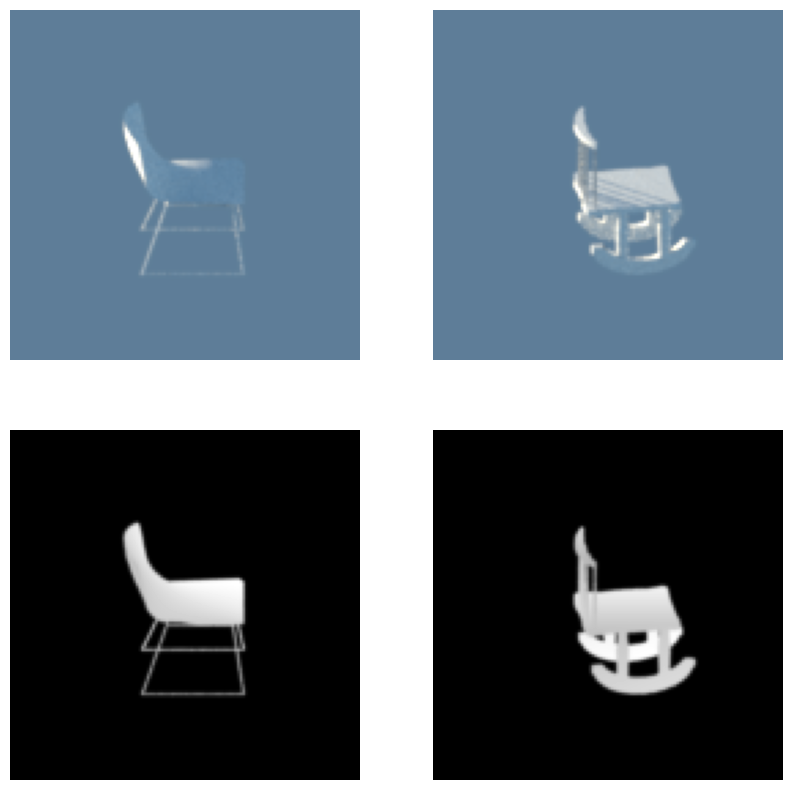

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor(0.0299, device='cuda:0')
tensor(0.2821, device='cuda:0')


In [27]:
SHOW = 2
fig, axs = plt.subplots(2, SHOW, figsize=(SHOW * 5, 2 * 5))
for i in range(SHOW * 2):
    ax = axs[i // SHOW, i % SHOW]
    ax.axis("off")
    if i < SHOW:
        ax.imshow(images[i][0:3].cpu().permute(1, 2, 0))
    else:
        ax.imshow(depths[i - SHOW][0].cpu(), cmap='gray')
plt.show()
print(depths[0][0])
print(depths[0][0].mean())
mask = depths[0][0] > 0.0
print(depths[0][0][mask].mean())

In [7]:
def conv2d_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, stride=2, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(),
    )

def deconv2d_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(),
    )

def linear_block(in_c, out_c):
    return nn.Sequential(
        nn.Linear(in_c, out_c),
        nn.BatchNorm1d(out_c),
        nn.ReLU(),
    )

def pixel_bias(outViewN, outW, outH, renderDepth):
    X, Y = torch.meshgrid([torch.arange(outH), torch.arange(outW)])
    X, Y = X.float(), Y.float() # [H,W]
    X = (X / (outH - 1) - 0.5) * 2
    Y = (Y / (outW - 1) - 0.5) * 2
    initTile = torch.cat([
        X.repeat([outViewN, 1, 1]), # [V,H,W]
        Y.repeat([outViewN, 1, 1]), # [V,H,W]
        torch.zeros([outViewN, outH, outW]).float() * renderDepth / 0.5, 
        torch.zeros([outViewN, outH, outW]).float(),
    ], dim=0) # [4V,H,W]

    return initTile.unsqueeze_(dim=0) # [1,4V,H,W]


class Encoder(nn.Module):
    """Encoder of Structure Generator"""
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = conv2d_block(3, 96)
        self.conv2 = conv2d_block(96, 128)
        self.conv3 = conv2d_block(128, 192)
        self.conv4 = conv2d_block(192, 256)
        self.conv5 = conv2d_block(256, 256) # New to make the size 4x4
        self.fc1 = linear_block(4096, 2048) # After flatten
        self.fc2 = linear_block(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 4096)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


class Decoder(nn.Module):
    """Build Decoder"""
    def __init__(self, outViewN, outW, outH, renderDepth):
        super(Decoder, self).__init__()
        self.outViewN = outViewN

        self.relu = nn.ReLU()
        self.fc1 = linear_block(512, 1024)
        self.fc2 = linear_block(1024, 2048)
        self.fc3 = linear_block(2048, 4096)
        self.deconv1 = deconv2d_block(256, 192)
        self.deconv2 = deconv2d_block(192, 128)
        self.deconv3 = deconv2d_block(128, 96)
        self.deconv4 = deconv2d_block(96, 64)
        self.deconv5 = deconv2d_block(64, 48)
        self.pixel_conv = nn.Conv2d(48, outViewN*4, 1, stride=1, bias=False)
        self.pixel_bias = pixel_bias(outViewN, outW, outH, renderDepth)

    def forward(self, x):
        x = self.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view([-1, 256, 4, 4])
        x = self.deconv1(F.interpolate(x, scale_factor=2))
        x = self.deconv2(F.interpolate(x, scale_factor=2))
        x = self.deconv3(F.interpolate(x, scale_factor=2))
        x = self.deconv4(F.interpolate(x, scale_factor=2))
        x = self.deconv5(F.interpolate(x, scale_factor=2))
        x = self.pixel_conv(x)
        x = x + self.pixel_bias.to(x.device)
        XYZ, maskLogit = torch.split(
            x, [self.outViewN * 3, self.outViewN], dim=1)
        return XYZ, maskLogit


class Structure_Generator(nn.Module):
    """Structure generator components in PCG"""

    def __init__(self, encoder=None, decoder=None,
                 outViewN=8, outW=128, outH=128, renderDepth=1.0):
        super(Structure_Generator, self).__init__()

        if encoder: self.encoder = encoder
        else: self.encoder = Encoder()

        if decoder: self.decoder = decoder
        else: self.decoder = Decoder(outViewN, outW, outH, renderDepth)

    def forward(self, x):
        latent = self.encoder(x)
        XYZ, maskLogit = self.decoder(latent)
        
        return XYZ, maskLogit

# Define the structure generator
structure_generator = Structure_Generator(None, None, NVIEW, SIZE, SIZE, 1.0)
structure_generator = structure_generator.to(device)
# print(structure_generator)

c:\Users\beltegeuse\projects\pytorch-3d-point-cloud-generation\.venv\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# Loss definition
l1_loss = nn.L1Loss()
bce_loss = nn.BCEWithLogitsLoss()
DEPTH_LAMBDA = 1.0
BATCHSIZE = 16
losses = []

In [9]:
 # ------ define ground truth------
XGT, YGT = torch.meshgrid([
    torch.arange(SIZE), # [H,W]
    torch.arange(SIZE)]) # [H,W]
XGT, YGT = XGT.float(), YGT.float()
XGT = (XGT / (SIZE - 1) - 0.5) * 2
YGT = (YGT / (SIZE - 1) - 0.5) * 2
XYGT = torch.cat([
    XGT.repeat([NVIEW, 1, 1]), 
    YGT.repeat([NVIEW, 1, 1])], dim=0) #[2V,H,W]
XYGT = XYGT.to(device) # [1,2V,H,W]
XYGT = torch.stack([XYGT for _ in range(BATCHSIZE)], dim=0) # [B,2V,H,W]
print(XGT)

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
        [-0.9685, -0.9685, -0.9685,  ..., -0.9685, -0.9685, -0.9685],
        ...,
        [ 0.9685,  0.9685,  0.9685,  ...,  0.9685,  0.9685,  0.9685],
        [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])


In [33]:
# Test
random.seed(SEED)
def random_sample(images, depths):
    id = random.randint(0, len(images)-1)
    viewid = random.randint(0, NVIEW-1)
    image = images[id][viewid * 3: (viewid + 1) * 3, :, :]
    depth = depths[id]
    return image, depth

jobs = []
for i in range(len(images)):
    for j in range(NVIEW):
        jobs.append((i, j))

# Create optimizer
optimizer = torch.optim.Adam(structure_generator.parameters(), lr=1e-5)
structure_generator.train()

EPOCHS = 50
for e in range(EPOCHS):
    random.shuffle(jobs)
    avg_loss = 0
    N_STEPS = len(jobs) // BATCHSIZE
    pbar = tqdm(total=N_STEPS, file=sys.stdout)
    for i in range(0, len(jobs), BATCHSIZE):
        optimizer.zero_grad()
        
        batch_images = []
        batch_depths = []
        batch_masks = []
        for k in range(BATCHSIZE):
            d = (i + k) % len(jobs)
            image = images[jobs[d][0]][jobs[d][1] * 3: (jobs[d][1] + 1) * 3, :, :]
            depth = depths[jobs[d][0]]
            batch_images.append(image)
            batch_depths.append(depth)
            batch_masks.append((depth > 0).to(torch.float))
        
        batch_images = torch.stack(batch_images, dim=0).to(device)
        batch_depths = torch.stack(batch_depths, dim=0).to(device)
        batch_masks = torch.stack(batch_masks, dim=0).to(device)
        # Run model
        XYZ, maskLogit = structure_generator(batch_images)

        # Extract data
        XY = XYZ[:, :NVIEW * 2, :, :]
        depth = XYZ[:, NVIEW * 2:NVIEW * 3, :,  :]
        mask = (maskLogit > 0).to(torch.bool)

        loss_XYZ = l1_loss(XY, XYGT)
        loss_XYZ += l1_loss(depth.masked_select(mask),
                            batch_depths.masked_select(mask))
        loss_mask = bce_loss(maskLogit, batch_masks)
        loss = loss_mask + DEPTH_LAMBDA * loss_XYZ
        
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        pbar.set_description('step: %d / %d | loss: %f' % (e, EPOCHS, avg_loss / (i // BATCHSIZE + 1)))
        pbar.update(1)
    losses.append(avg_loss / N_STEPS)


  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/972 [00:00<?, ?it/s]

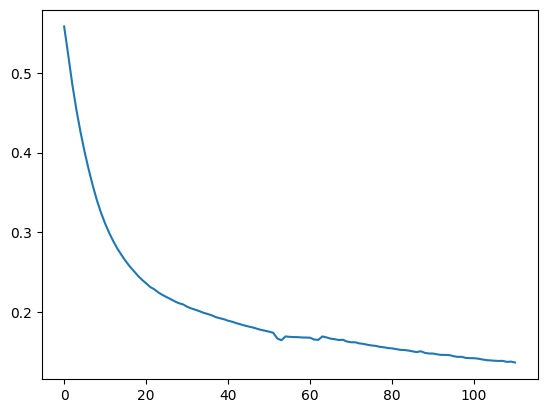

In [30]:
# Print loss
plt.plot(losses)
plt.show()

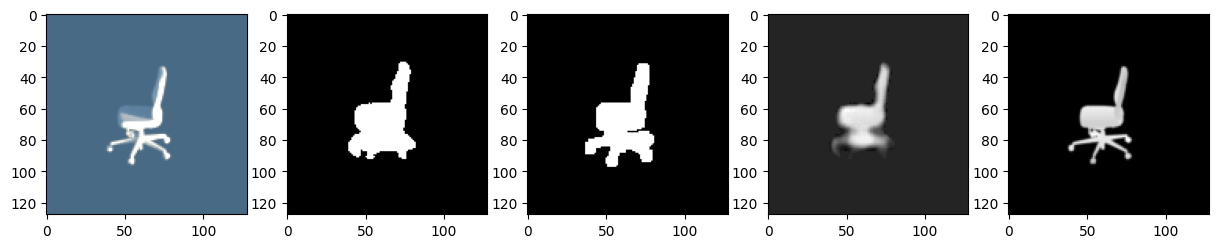

In [31]:
structure_generator.eval()
id = random.randint(0, len(images)-1)
viewid = random.randint(0, NVIEW-1)
image = images[id][viewid * 3: (viewid + 1) * 3, :, :]
depth = depths[id]
image = image.unsqueeze(0).to(device)
pred_XYZ, pred_maskLogit = structure_generator(image)
pred_XYZ = pred_XYZ[0]
maskLogit = pred_maskLogit[0]

pred_XY = pred_XYZ[:NVIEW * 2, :, :]
pred_depth = pred_XYZ[NVIEW * 2:NVIEW * 3, :,  :]
pred_mask = (maskLogit > 0).to(torch.bool)
pred_mask_depth = pred_depth.clone()
pred_mask_depth[maskLogit <= 0] = 0

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs[0].imshow(image[0, :3].cpu().permute(1, 2, 0))
axs[1].imshow(pred_mask[viewid].cpu().numpy(), cmap='gray')
axs[2].imshow((depth > 0)[viewid].to(torch.float).cpu().numpy(), cmap='gray')
axs[3].imshow(pred_mask_depth[viewid].cpu().detach().numpy(), cmap='gray')
axs[4].imshow(depth[viewid].cpu().detach().numpy(), cmap='gray')
plt.show()



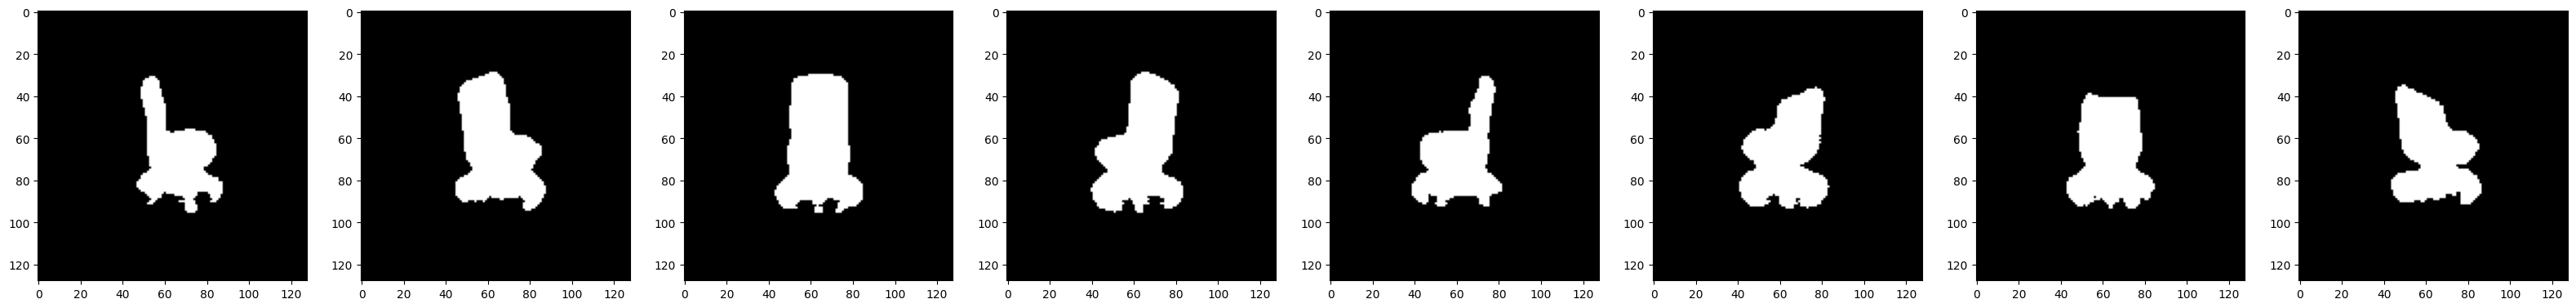

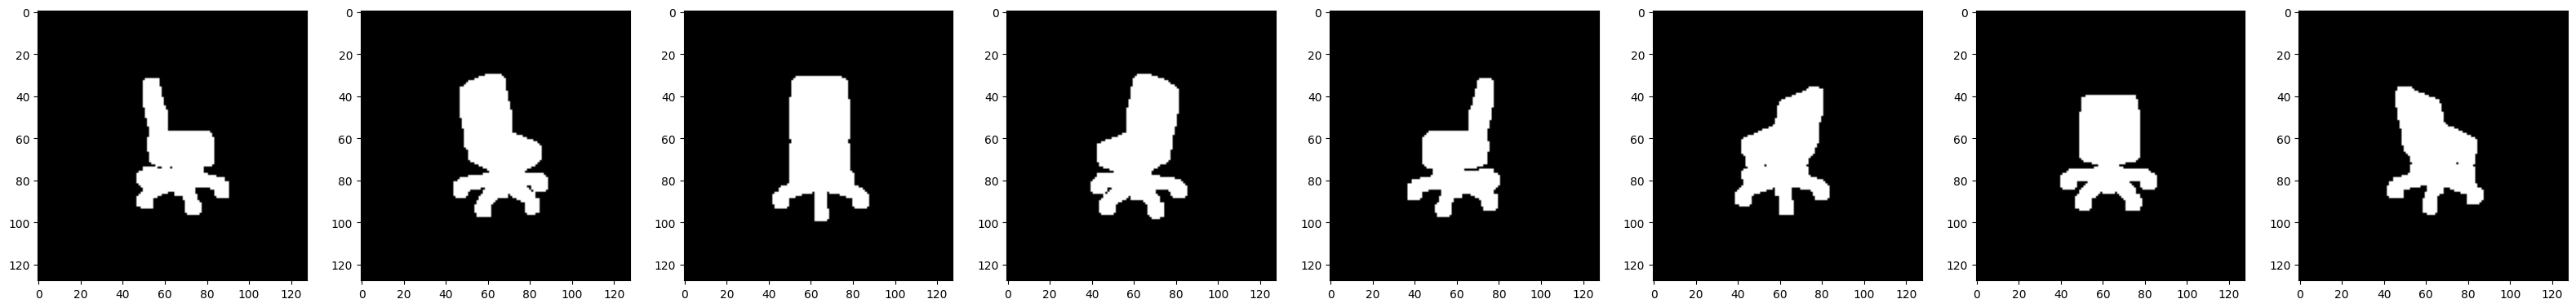

In [32]:
# Check all views
fig, axs = plt.subplots(1, NVIEW, figsize=(NVIEW * 5, 5))
for i in range(NVIEW):
    axs[i].imshow(pred_mask[i].cpu().numpy(), cmap='gray')
plt.show()

# Check all views
fig, axs = plt.subplots(1, NVIEW, figsize=(NVIEW * 5, 5))
for i in range(NVIEW):
    axs[i].imshow((depth > 0)[i].to(torch.float).cpu().numpy(), cmap='gray')
plt.show()